In [ ]:
import torch
import os
import os.path
import cv2
import numpy as np
import torchvision
from torch.utils.data import Dataset
import transform as tfs
from torch.utils.data import DataLoader
from cityscapes_dataset import Cityscapes
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch import nn
from pspnet import *

# Set device
device = 'cpu'

# Loss Criterion
criterion = nn.CrossEntropyLoss(ignore_index=255)

model = PSPNet(layers=50, bins=(2, 3, 6, 8), dropout=0.1, classes=35, zoom_factor=8, use_ppm=True, pretrained=True, criterion=criterion).to(device)

# Load the state dictionary from the train_epoch_200_CPU.pth file
state_dict = torch.load('train_epoch_200_CPU.pth', map_location=device)

# Load the state dict into the model
model.load_state_dict(state_dict)

# Get the current directory of the notebook
current_directory = os.getcwd()

# Navigate to the directory containing fine_val.txt
file_directory = os.path.join(current_directory, "../cityscapes_dataset/list/cityscapes")

# Read the file
file_path = os.path.join(file_directory, "fine_val.txt")
with open(file_path, "r") as file:
    content = file.read()

print(current_directory)
print(file_path)

# Dataset
dataset_val = Cityscapes(split='val',
                           data_root='../cityscapes_dataset', 
                           data_list=file_path)

# Dataloader
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=8)

model.eval()
output = [] 
all_labels = []

val_losses = []

# Process the dataset
for i, (images, labels) in enumerate(val_dataloader):
    # Move images to the configured device
    # images = images.to(device)
    
    with torch.no_grad():
        # Forward pass to get the output from the model
        output.append(model(images.to(device)))
    
    all_labels.append(labels.cpu().numpy())

(713, 713)
(6, 1, 713, 713)


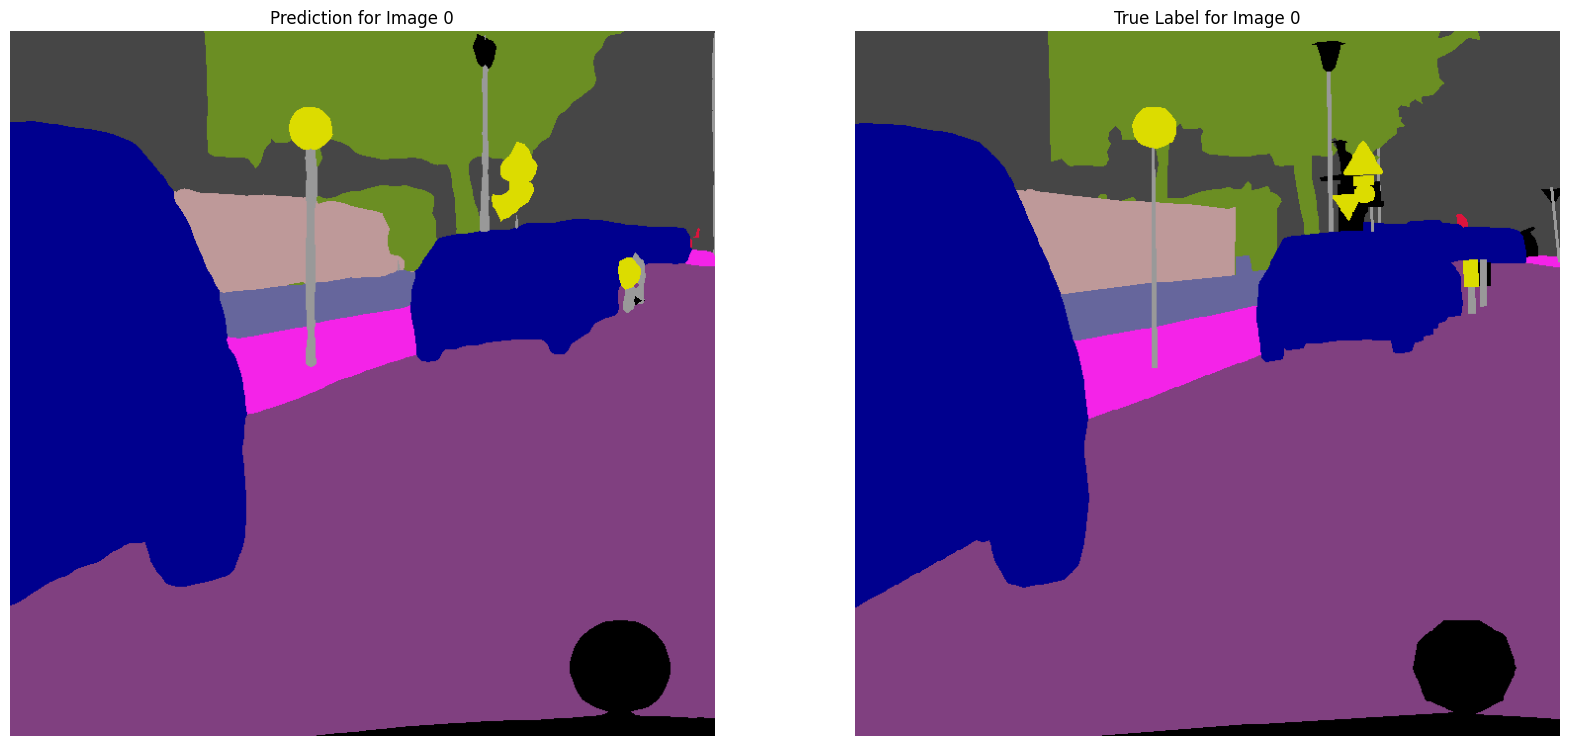

(713, 713)
(6, 1, 713, 713)


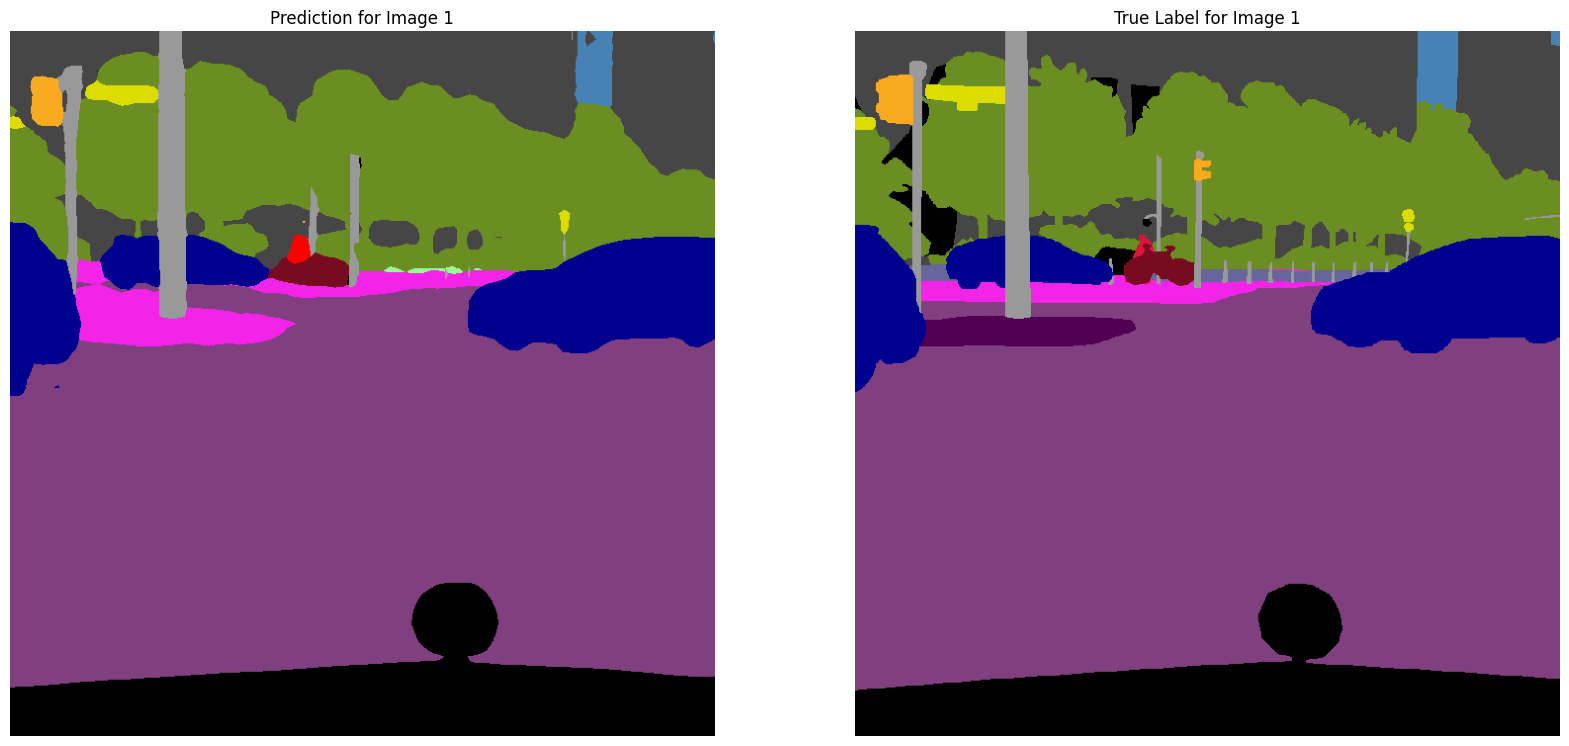

(713, 713)
(6, 1, 713, 713)


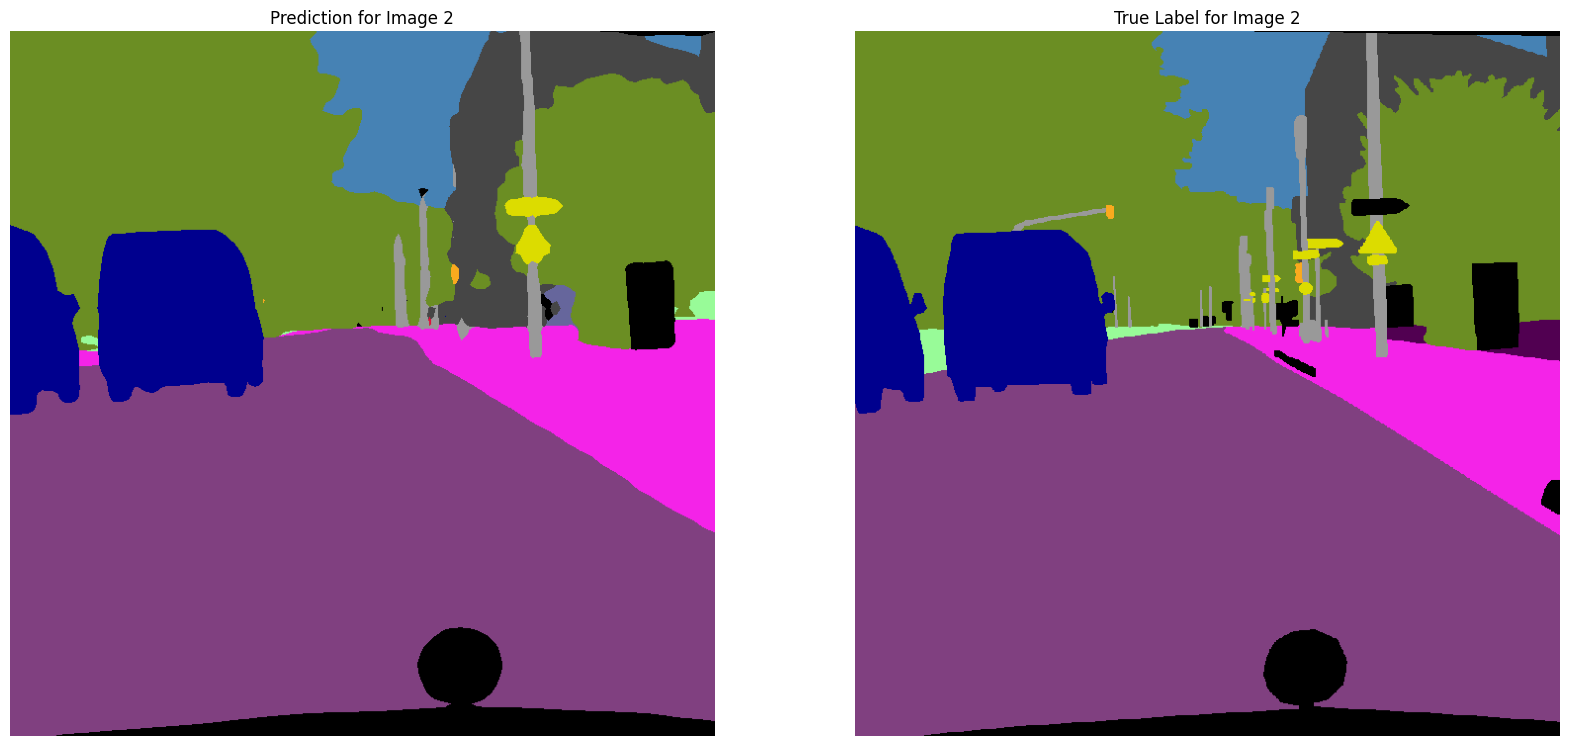

(713, 713)
(6, 1, 713, 713)


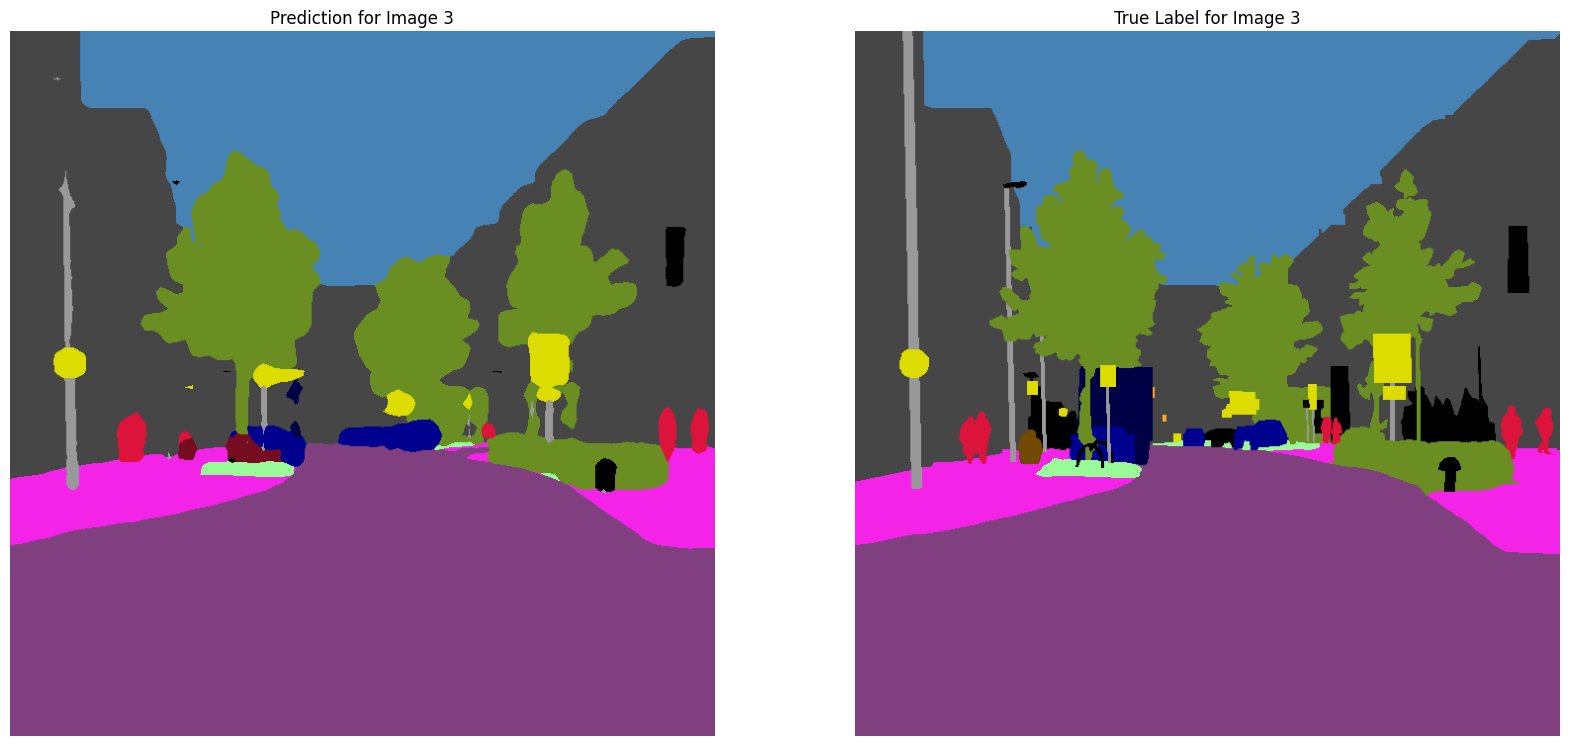

(713, 713)
(6, 1, 713, 713)


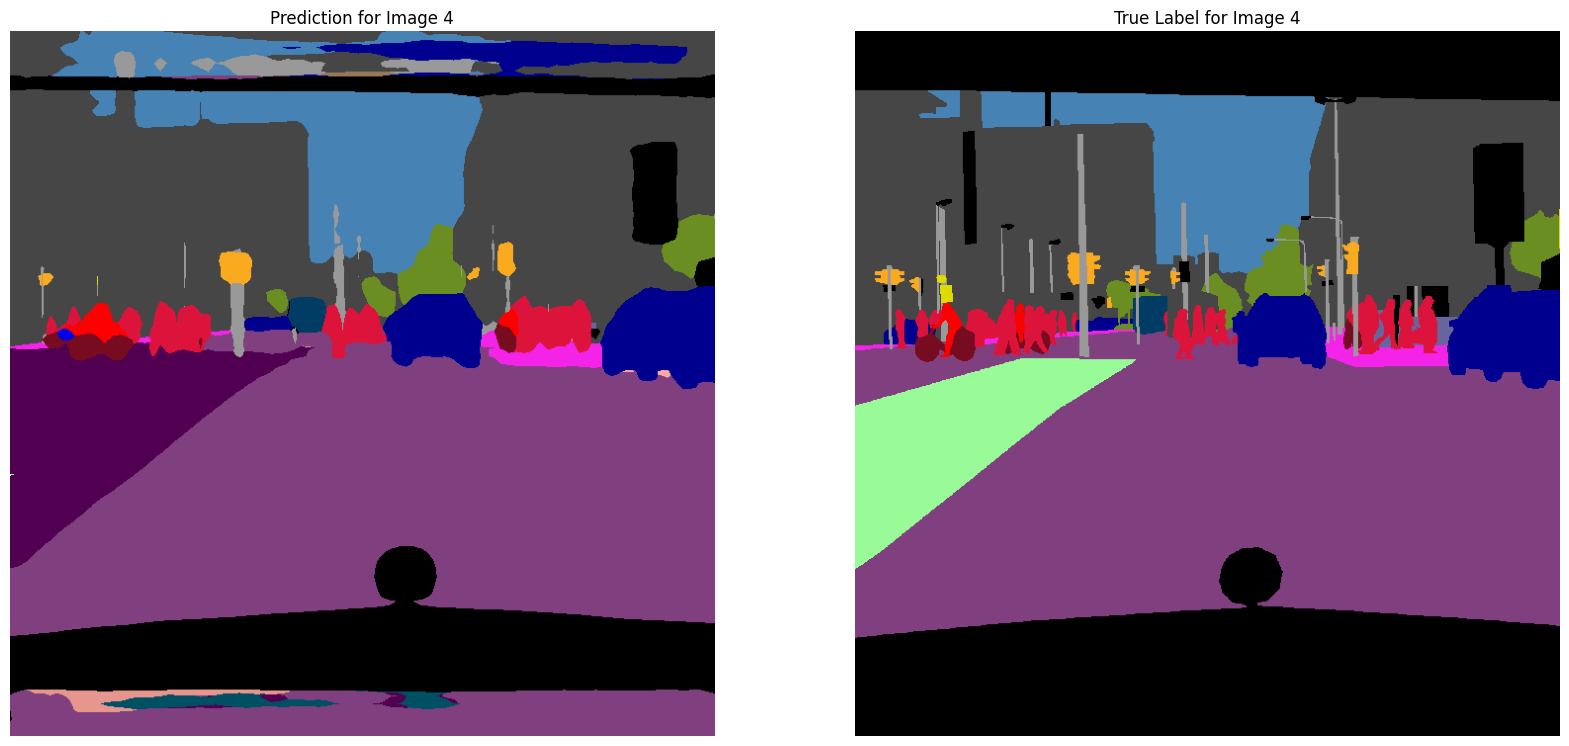

(713, 713)
(6, 1, 713, 713)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002711AF1AF80>
Traceback (most recent call last):
  File "c:\Users\ν\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\ν\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


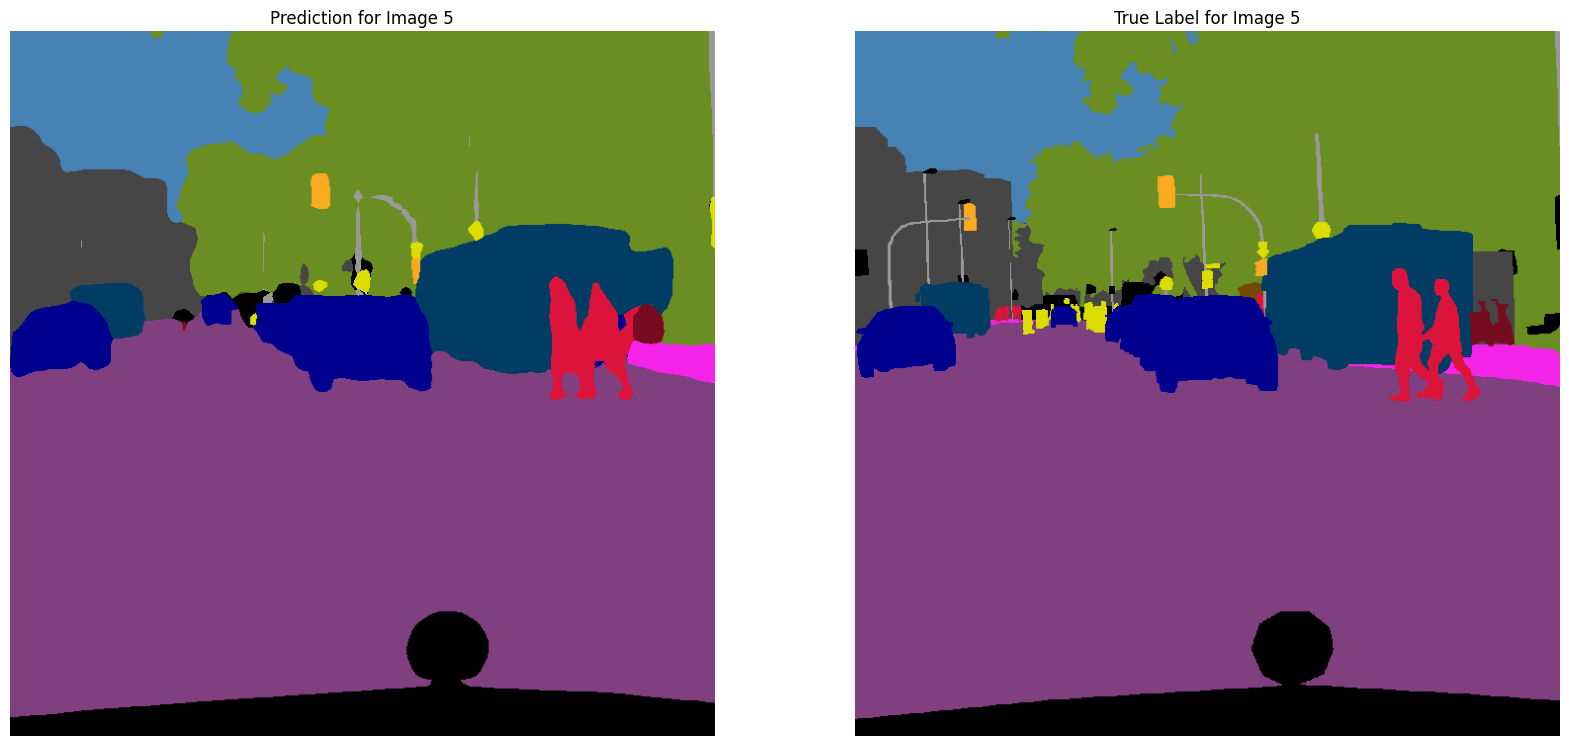

In [8]:
color_palette = {
    0: [0, 0, 0],         # unlabeled
    1: [0, 0, 0],         # ego vehicle
    2: [0, 0, 0],         # rectification border
    3: [0, 0, 0],         # out of roi
    4: [0, 0, 0],         # static
    5: [111, 74, 0],      # dynamic
    6: [81, 0, 81],       # ground
    7: [128, 64, 128],    # road
    8: [244, 35, 232],    # sidewalk
    9: [250, 170, 160],   # parking
    10: [230, 150, 140],  # rail track
    11: [70, 70, 70],     # building
    12: [102, 102, 156],  # wall
    13: [190, 153, 153],  # fence
    14: [180, 165, 180],  # guard rail
    15: [150, 100, 100],  # bridge
    16: [150, 120, 90],   # tunnel
    17: [153, 153, 153],  # pole
    18: [153, 153, 153],  # polegroup
    19: [250, 170, 30],   # traffic light
    20: [220, 220, 0],    # traffic sign
    21: [107, 142, 35],   # vegetation
    22: [152, 251, 152],  # terrain
    23: [70, 130, 180],   # sky
    24: [220, 20, 60],    # person
    25: [255, 0, 0],      # rider
    26: [0, 0, 142],      # car
    27: [0, 0, 70],       # truck
    28: [0, 60, 100],     # bus
    29: [0, 0, 90],       # caravan
    30: [0, 0, 110],      # trailer
    31: [0, 80, 100],     # train
    32: [0, 0, 230],      # motorcycle
    33: [119, 11, 32],    # bicycle
    34: [0, 0, 142]       # license plate
}


def decode_segmap(image, color_palette):
    # Create an empty image with 3 channels for RGB, initialized to zeros (black)
    color_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # Map each class index to its corresponding color
    for class_idx, color in color_palette.items():
        color_image[image == class_idx] = color
    return color_image

for j in range(len(output)):  # Loop over the batch dimension
    prediction = output[j].max(1)[1]
    predictions_np = prediction[0].cpu().numpy()  # Convert the ith prediction to a NumPy array
    print(predictions_np.shape)
    # Convert predictions and labels to color images
    pred_color_image = decode_segmap(predictions_np, color_palette)  # Assuming batch size of 1 for simplicity
    
    # Do the same for the labels
    labels_np = np.array(all_labels)
    print(labels_np.shape)
    label_color_image = decode_segmap(labels_np[j][0], color_palette)  # Assuming batch size of 1
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Create a figure with two subplots side-by-side
    axes[0].imshow(pred_color_image)
    axes[0].set_title(f"Prediction for Image {j}")
    axes[0].axis('off')  # Hide axes ticks for the first subplot
    
    axes[1].imshow(label_color_image)
    axes[1].set_title(f"True Label for Image {j}")
    axes[1].axis('off')  # Hide axes ticks for the second subplot
    
    plt.show()

In [ ]:
# Initialize dictionaries to hold the intersection and union areas for each class
intersections = {class_id: 0 for class_id in color_palette.keys()}
unions = {class_id: 0 for class_id in color_palette.keys()}

# Initialize a dictionary to hold lists of IoUs for each class
ious_per_class = {class_id: [] for class_id in color_palette.keys()}

# Initialize a dictionary to hold the mean value of IoUs for each image
ious_images = {image_id: 0 for image_id in range(len(output))}

img_idx = 0
# Iterate over all predictions and corresponding labels
for pred, true in zip(output, all_labels):
    pred = pred.max(1)[1].cpu().numpy().flatten()  # Flatten the prediction
    true = true.flatten()  # Flatten the true labels

    temp = {class_id: 0 for class_id in color_palette.keys()}

    # Calculate intersection and union for each class
    for class_id in color_palette.keys():
        pred_mask = (pred == class_id)
        true_mask = (true == class_id)
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        # Update the intersection and union counts for this class
        intersections[class_id] += intersection
        unions[class_id] += union

        # Calculate IoU for the current class and image/batch, if union > 0
        if union > 0:
            iou = intersection / union
            ious_per_class[class_id].append(iou)

            temp[class_id] = intersection / union

    ious_images[img_idx] = np.nanmean(list(temp.values()))
    img_idx +=1

# Calculate IoU for each class
ious = {class_id: (intersections[class_id] / unions[class_id] if unions[class_id] > 0 else np.nan) for class_id in color_palette.keys()}

# Calculate mean IoU across all classes, ignoring NaN values
mean_iou = np.nanmean(list(ious.values()))

# Calculate the variance of IoUs for each class
iou_variances = {class_id: np.var(ious) for class_id, ious in ious_per_class.items()}

# Calculate the mean IoU accross all images
mean_iou_images = np.nanmean(list(ious_images.values()))

# Calculate the variance of IoUs for all images
mean_iou_values = list(ious_images.values())
iou_variance_images = np.var(mean_iou_values)

print(type(ious))
print(type(iou_variances))

print("****************************")
print("Ious per class:")
for class_id, iou_mean in ious.items():
    print(class_id, ": ", iou_mean)
print("****************************")
print("Mean IoU:", mean_iou)
print("****************************")
print("Ious variance per class:")
for class_id, iou_var in iou_variances.items():
    print(class_id, ": ", iou_var)
print("****************************")
print("Ious mean per image:")
for img_idx,img_mean in ious_images.items():
    print(img_idx, ": ", img_mean)
print("****************************")
print("Iou images variance: ",iou_variance_images)
print("****************************")
print("mean iou images: ", mean_iou_images)